In [2]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [4]:
return_2_yrs = pd.read_parquet(r'C:\Users\Dell\Desktop\algo-trading5210\return_minute.pqt')

return_2_yrs = return_2_yrs[~return_2_yrs['time'].isin(['14:56','14:57','14:58', '14:59', '15:00'])] 
return_2_yrs = return_2_yrs.dropna(how='any')
return_2_yrs['vwap'] = return_2_yrs['amount']/(return_2_yrs['volume']*100).round(2) # 这里volume的单位是手

return_2_yrs = return_2_yrs.dropna()
return_2_yrs.head()

,code,date,time,open,high,low,close,volume,amount,vwap
0,1,20220104,09:31,16.480000,16.500000,16.440001,16.459999,36924,60816580,16.470745
1,1,20220104,09:32,16.459999,16.459999,16.360001,16.370001,15569,25554244,16.413542
2,1,20220104,09:33,16.350000,16.360001,16.250000,16.270000,24743,40321696,16.296203
3,1,20220104,09:34,16.280001,16.309999,16.270000,16.309999,13607,22162056,16.287246
4,1,20220104,09:35,16.309999,16.350000,16.309999,16.350000,8237,13450944,16.329907


In [ ]:
return_2_yrs['vwap'] = np.minimum(return_2_yrs['high'],return_2_yrs['vwap'])
return_2_yrs['vwap'] = np.maximum(return_2_yrs['low'],return_2_yrs['vwap'])
return_2_yrs['vwap_high'] = (return_2_yrs['high']-return_2_yrs['vwap'])**(return_2_yrs['vwap']-return_2_yrs['low'])

In [141]:
return_2_yrs

,code,date,time,open,high,low,close,volume,amount,vwap,vwap_high
0,1,20220104,09:31,16.480000,16.500000,16.440001,16.459999,36924,60816580,16.470745,0.897105
1,1,20220104,09:32,16.459999,16.459999,16.360001,16.370001,15569,25554244,16.413542,0.848460
2,1,20220104,09:33,16.350000,16.360001,16.250000,16.270000,24743,40321696,16.296203,0.880598
3,1,20220104,09:34,16.280001,16.309999,16.270000,16.309999,13607,22162056,16.287246,0.936841
4,1,20220104,09:35,16.309999,16.350000,16.309999,16.350000,8237,13450944,16.329907,0.925165
...,...,...,...,...,...,...,...,...,...,...,...
65274950,689009,20231229,14:51,29.780001,29.809999,29.690001,29.690001,381,1133767,29.757664,0.819048
65274951,689009,20231229,14:52,29.690001,29.709999,29.660000,29.680000,341,1011307,29.660000,1.000000
65274952,689009,20231229,14:53,29.700001,29.700001,29.670000,29.690001,174,518061,29.700001,0.000000
65274953,689009,20231229,14:54,29.700001,29.709999,29.680000,29.690001,190,562845,29.680000,1.000000


In [142]:
vwap_factor = return_2_yrs.groupby(['code', 'date'],as_index=False)['vwap_high'].mean()
vwap_factor

,code,date,vwap_high
0,1,20220104,0.956339
1,1,20220105,0.940042
2,1,20220106,0.926560
3,1,20220107,0.952668
4,1,20220110,0.950941
...,...,...,...
386842,689009,20231225,0.606643
386843,689009,20231226,0.643991
386844,689009,20231227,0.615358
386845,689009,20231228,0.640457


In [143]:
stock_return = pd.read_csv('stock_800.csv')
stock_return = stock_return.sort_values(by=['Symbol', 'Date'])
#把因子和收益率两张表合并在一起
vwap_factor = vwap_factor.merge(stock_return, left_on=['code','date'], right_on=['Symbol','Date']).drop(columns=['Date','Symbol'])
vwap_factor = vwap_factor.sort_values(by=['date','code'])

In [144]:
# 针对micro_volatility进行分组
vwap_factor['rank'] = (
    vwap_factor
    .groupby('date')['vwap_high']
    .transform(lambda x: x.rank(method='first'))
)
vwap_factor.head()

,code,date,vwap_high,open,high,low,close,pre_close,volume,amount,...,stock_800,return_inday,return_overnight,return_1min,return_5min,return_10min,return_30min,return_1hr,return_2hr,rank
0,1,20220104,0.956339,16.48,16.66,16.18,16.66,16.48,116925933.0,1.918887e+09,...,True,0.010922,-0.004802,-0.001214,-0.007888,-0.014563,-0.015777,-0.012743,-0.004248,624.0
484,2,20220104,0.922197,19.49,20.65,19.36,20.49,19.76,194720202.0,3.956476e+09,...,True,0.051308,-0.002928,-0.000513,-0.003079,0.000513,0.029759,0.038481,0.051821,369.0
968,9,20220104,0.944752,14.64,14.64,13.75,14.00,14.43,103580537.0,1.451934e+09,...,True,-0.043716,0.000000,-0.004098,-0.020492,-0.019809,-0.035519,-0.050546,-0.051913,511.0
1452,12,20220104,0.944849,9.90,10.19,9.82,9.90,9.93,20580051.0,2.045465e+08,...,True,0.000000,0.000000,0.003030,0.006061,0.024242,-0.001010,-0.004040,0.006061,512.0
1936,21,20220104,0.931558,15.80,16.29,15.79,16.13,15.84,18009540.0,2.900648e+08,...,True,0.020886,0.004340,0.006329,0.008228,0.006962,0.021519,0.017089,0.018354,410.0


In [145]:
vwap_factor = vwap_factor.dropna()

In [146]:
vwap_factor = vwap_factor.sort_values(by=['code','date'])
vwap_factor['group'] = vwap_factor.groupby(['date'])['rank'].transform(lambda x: (80*x.rank(method='first')/len(x)).astype('int'))
vwap_factor

,code,date,vwap_high,open,high,low,close,pre_close,volume,amount,...,return_inday,return_overnight,return_1min,return_5min,return_10min,return_30min,return_1hr,return_2hr,rank,group
0,1,20220104,0.956339,16.48,16.66,16.18,16.66,16.48,116925933.0,1.918887e+09,...,0.010922,-0.004802,-0.001214,-0.007888,-0.014563,-0.015777,-0.012743,-0.004248,624.0,62
1,1,20220105,0.940042,16.58,17.22,16.55,17.15,16.66,196199817.0,3.344125e+09,...,0.034379,-0.002332,0.004825,0.014475,0.020507,0.029554,0.024729,0.033172,468.0,46
2,1,20220106,0.926560,17.11,17.27,17.00,17.12,17.15,110788519.0,1.896536e+09,...,0.000584,-0.001168,-0.002922,-0.005845,-0.004091,0.006429,-0.000584,-0.002338,374.0,37
3,1,20220107,0.952668,17.10,17.28,17.06,17.20,17.12,112663070.0,1.937711e+09,...,0.005848,0.005233,-0.000585,0.002339,0.004094,0.006433,0.001754,0.008772,574.0,57
4,1,20220110,0.950941,17.29,17.42,17.03,17.19,17.20,90977401.0,1.563415e+09,...,-0.005784,0.004072,-0.001157,0.006362,-0.004049,-0.009254,-0.011567,-0.008676,575.0,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386841,689009,20231222,0.631770,31.28,31.70,30.70,31.06,31.30,3036142.0,9.394331e+07,...,-0.007033,-0.006761,0.000959,-0.008632,-0.012468,-0.015985,-0.016944,-0.007033,36.0,3
386842,689009,20231225,0.606643,30.85,31.20,30.06,30.08,31.06,3591121.0,1.096494e+08,...,-0.024959,0.001995,0.002917,0.009724,0.009724,0.002593,0.003566,-0.014587,26.0,2
386843,689009,20231226,0.643991,30.14,30.25,26.00,27.85,30.08,9042296.0,2.519455e+08,...,-0.075979,0.001795,-0.002654,-0.031188,-0.035833,-0.081287,-0.089914,-0.065030,37.0,3
386844,689009,20231227,0.615358,27.90,28.89,27.18,28.89,27.85,5488847.0,1.551564e+08,...,0.035484,-0.010730,-0.002151,0.006093,0.000000,-0.008961,-0.001792,0.007168,38.0,3


In [147]:
portfolio_daily_return = (
    vwap_factor
    .groupby(['date', 'group'])['return_overnight']
    .mean()
    .reset_index()
)

portfolio_daily_return = portfolio_daily_return.sort_values(by=['date'])

In [148]:
# 看看哪组的收益率表现最好
list1 = []
max_return = 0
max_group = 0
for i in range(1, 81):
    group_df = portfolio_daily_return[portfolio_daily_return['group']==i]
    group_df = group_df.sort_values(by=['date'])
    cum_ret = (1 + group_df['return_overnight']).cumprod()
    # 年化收益率
    if not cum_ret.empty:
        # print(cum_ret.iloc[-1])
        list1.append(cum_ret.iloc[-1])
        if cum_ret.iloc[-1] > max_return:
            max_return = cum_ret.iloc[-1]
            max_group = i
    else:
        print("该组为空，跳过")
    

print(max(list1),max_group)

1.9989644930538466 79


In [149]:
# 选取最大的组构建投资组合
group_df = portfolio_daily_return[portfolio_daily_return['group']==max_group]


group_df = group_df.sort_values(by=['date'])
group_df['cum_return'] = (1 + group_df['return_overnight']).cumprod()
group_df = group_df.dropna()
group_df['date'] = pd.to_datetime(group_df['date'].astype('str'))

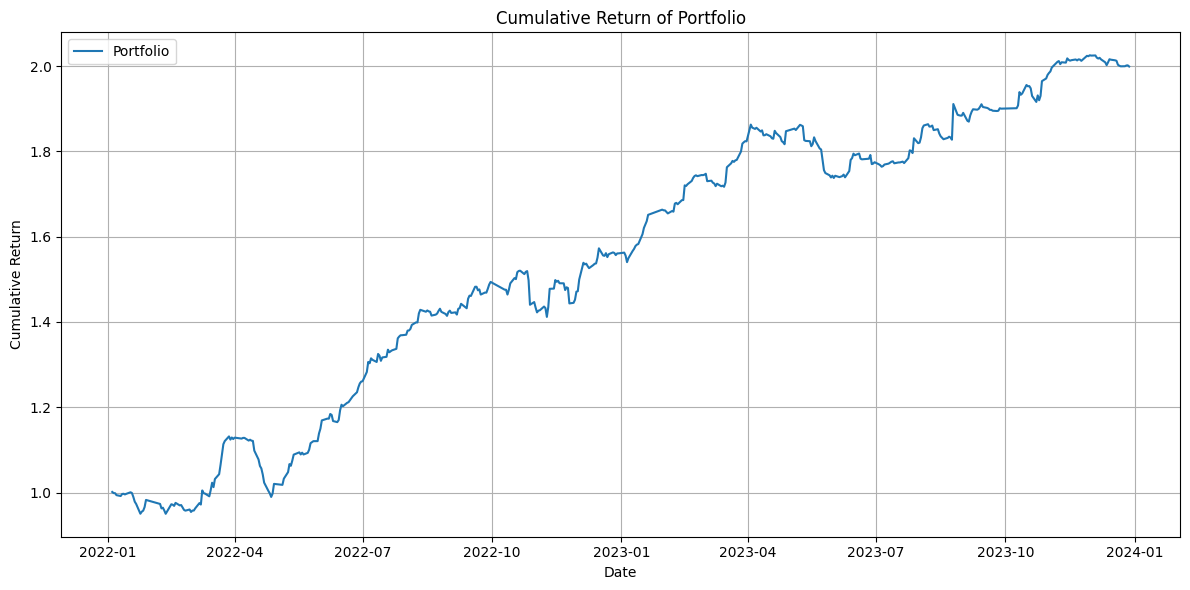

In [150]:
def plot_curve(df: pd.DataFrame, horizontal_name: str, cum_return_name: str):
    plt.figure(figsize=(12, 6))
    plt.plot(df[horizontal_name], df[cum_return_name], label='Portfolio')
    plt.legend()
    plt.title("Cumulative Return of Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return None
plot_curve(group_df, 'date', 'cum_return')

In [151]:
def cal_sharpe(df: pd.DataFrame, rf: float, return_name: str) -> int:
    df['excess_return'] = df[return_name] - rf/252
    return (np.sqrt(252)*group_df['excess_return'].mean())/(group_df[return_name]).std()

cal_sharpe(group_df, 0.017, 'return_overnight')

np.float64(2.797619199760045)